In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
weather_df = pd.read_csv(r'C:\Users\admin\Downloads\wea/testset.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
datetime_utc,,,,,,,,,,,,,,,,,,,
1996-11-01 11:00:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1996-11-01 12:00:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 13:00:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
1996-11-01 14:00:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
1996-11-01 16:00:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [3]:
weather_df = weather_df.loc[:,[' _conds', ' _hum', ' _tempm']]
weather_df = weather_df.rename(index=str, columns={' _conds': 'condition', ' _hum': 'humidity', ' _pressurem': 'pressure', ' _tempm': 'temprature'})
print(f'dataset shape (rows, columns) - {weather_df.shape}')
weather_df.head()

dataset shape (rows, columns) - (100990, 3)


,condition,humidity,temprature
datetime_utc,,,
1996-11-01 11:00:00,Smoke,27.0,30.0
1996-11-01 12:00:00,Smoke,32.0,28.0
1996-11-01 13:00:00,Smoke,44.0,24.0
1996-11-01 14:00:00,Smoke,41.0,24.0
1996-11-01 16:00:00,Smoke,47.0,23.0


In [4]:
# dtype of all columns 
weather_df.dtypes, weather_df.index.dtype

(condition      object
 humidity      float64
 temprature    float64
 dtype: object,
 dtype('O'))

In [5]:
weather_df.index = pd.to_datetime(weather_df.index)
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)

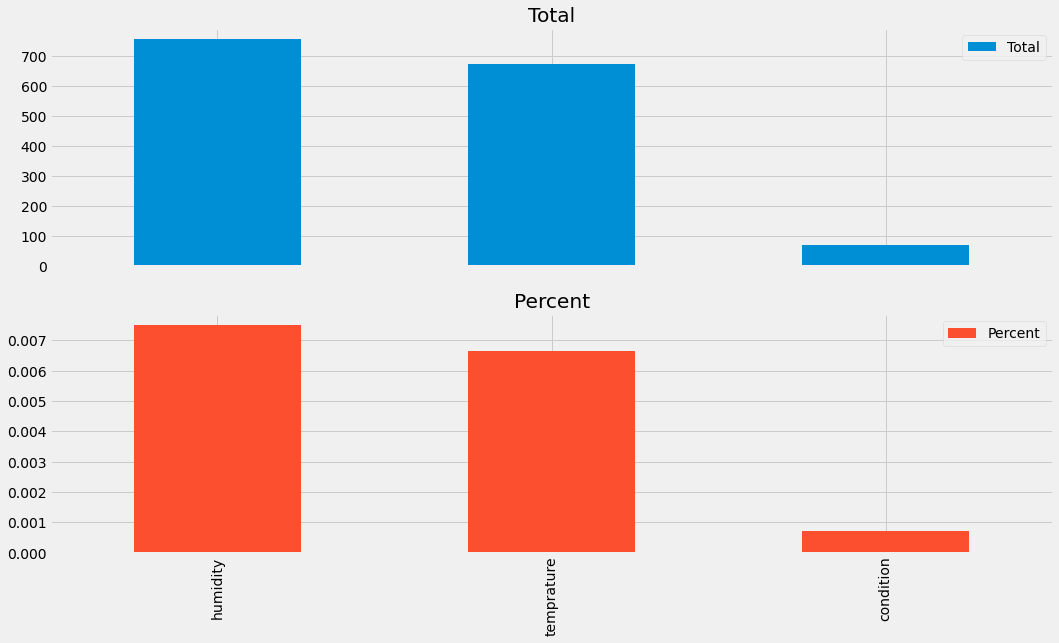

In [6]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    
    missing_data.plot.bar(subplots=True, figsize=(16,9))

list_and_visualize_missing_data(weather_df)


In [7]:
weather_df.ffill(inplace=True)
weather_df[weather_df.isnull()].count()

condition     0
humidity      0
temprature    0
dtype: int64

In [8]:
weather_df.describe()

,humidity,temprature
count,100990.000000,100990.000000
mean,57.957422,25.438222
std,23.821218,8.487994
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,243.000000,90.000000


In [9]:
weather_df = weather_df[weather_df.temprature < 50]
weather_df = weather_df[weather_df.humidity <= 100]

Text(0, 0.5, 'Percent')

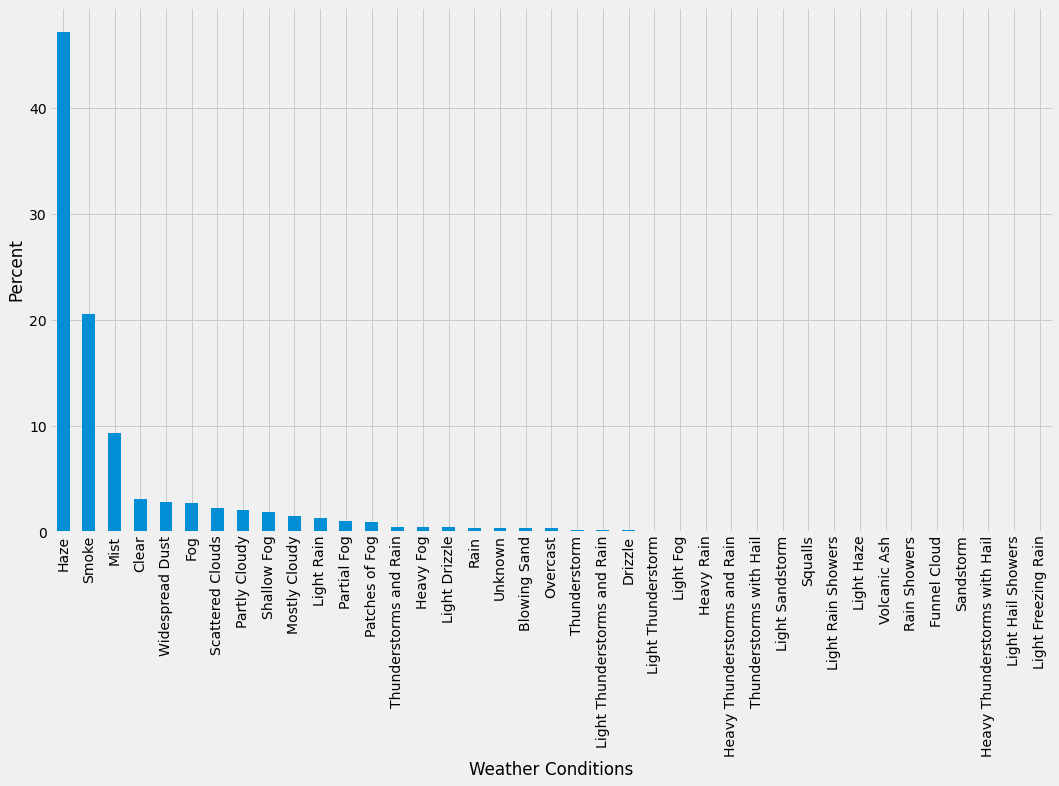

In [10]:
weather_condition = (weather_df.condition.value_counts()/(weather_df.condition.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')

array([<AxesSubplot:xlabel='datetime_utc'>,
       <AxesSubplot:xlabel='datetime_utc'>], dtype=object)

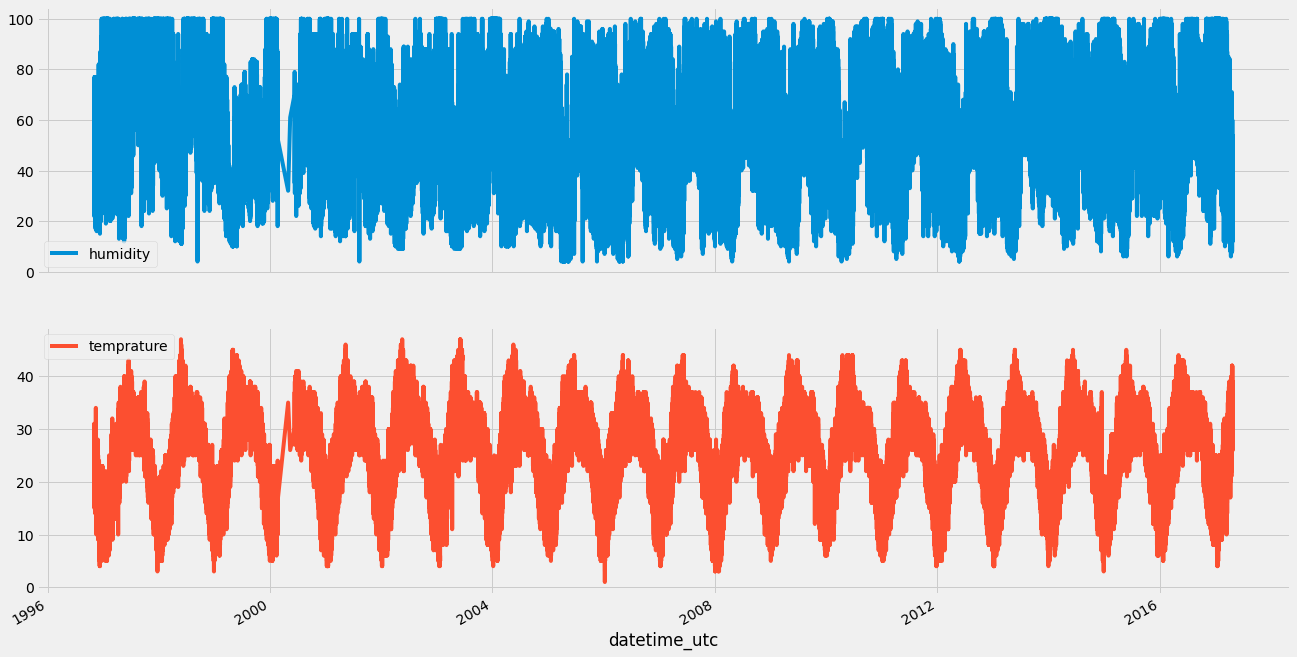

In [11]:
weather_df.plot(subplots=True, figsize=(20,12))

array([<AxesSubplot:xlabel='datetime_utc'>,
       <AxesSubplot:xlabel='datetime_utc'>], dtype=object)

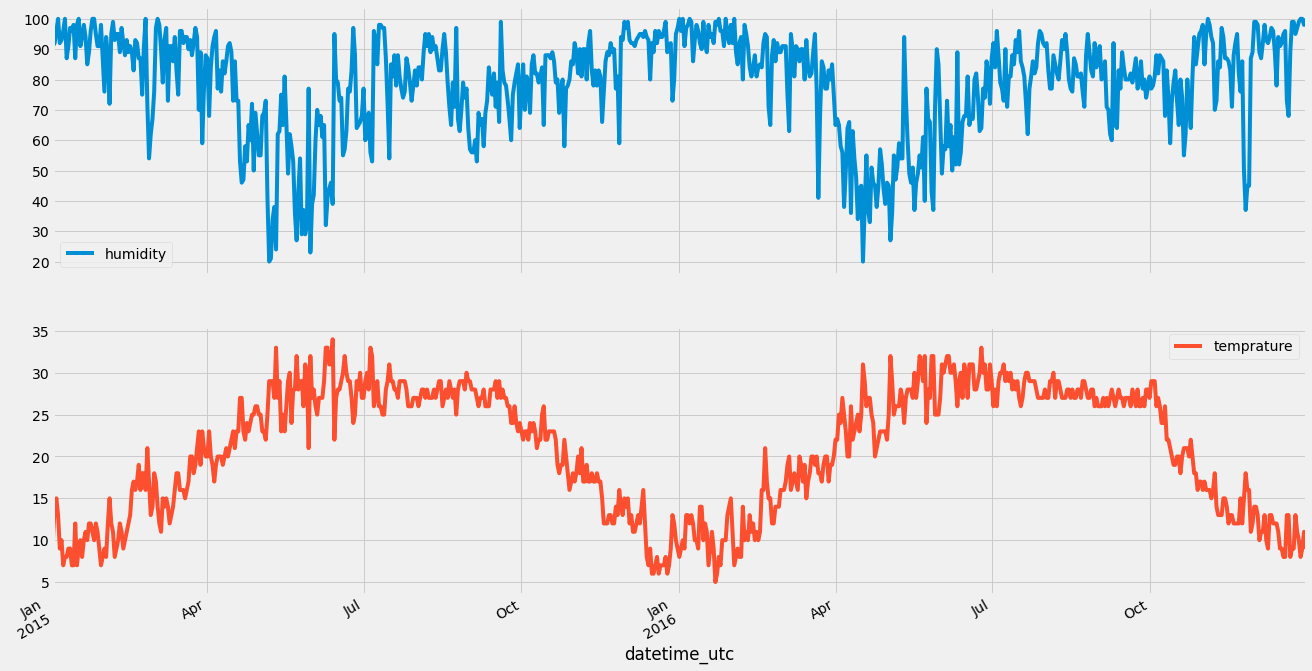

In [12]:
weather_df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

In [13]:
train_df = weather_df['2000':'2015'].resample('M').mean().fillna(method='pad')
train_df.drop(columns='humidity', axis=1, inplace=True)
test_df = weather_df['2016':'2017'].resample('M').mean().fillna(method='pad')
test_df.drop(columns='humidity', axis=1, inplace=True)

In [14]:
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [15]:
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

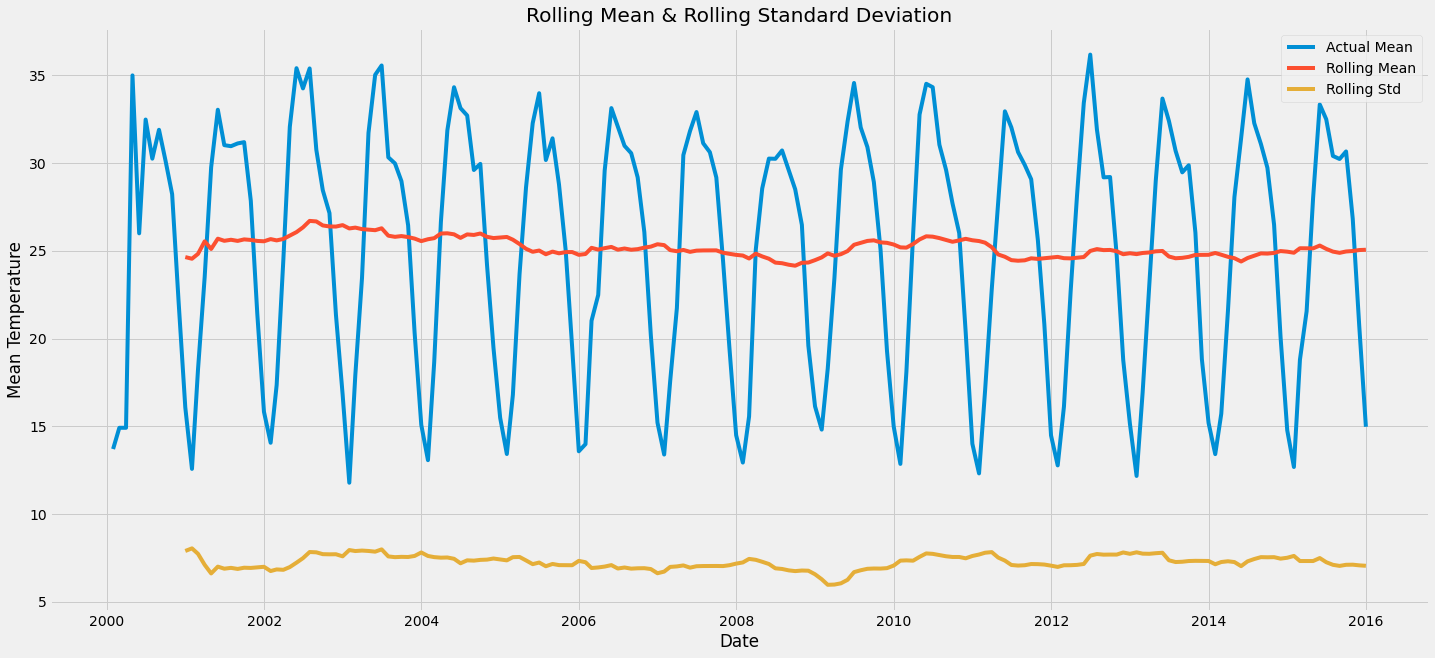

Test statistic:  -4.612786972415764
Critical Values: {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}


In [16]:
plot_rolling_mean_std(train_df.temprature)
perform_dickey_fuller_test(train_df.temprature)

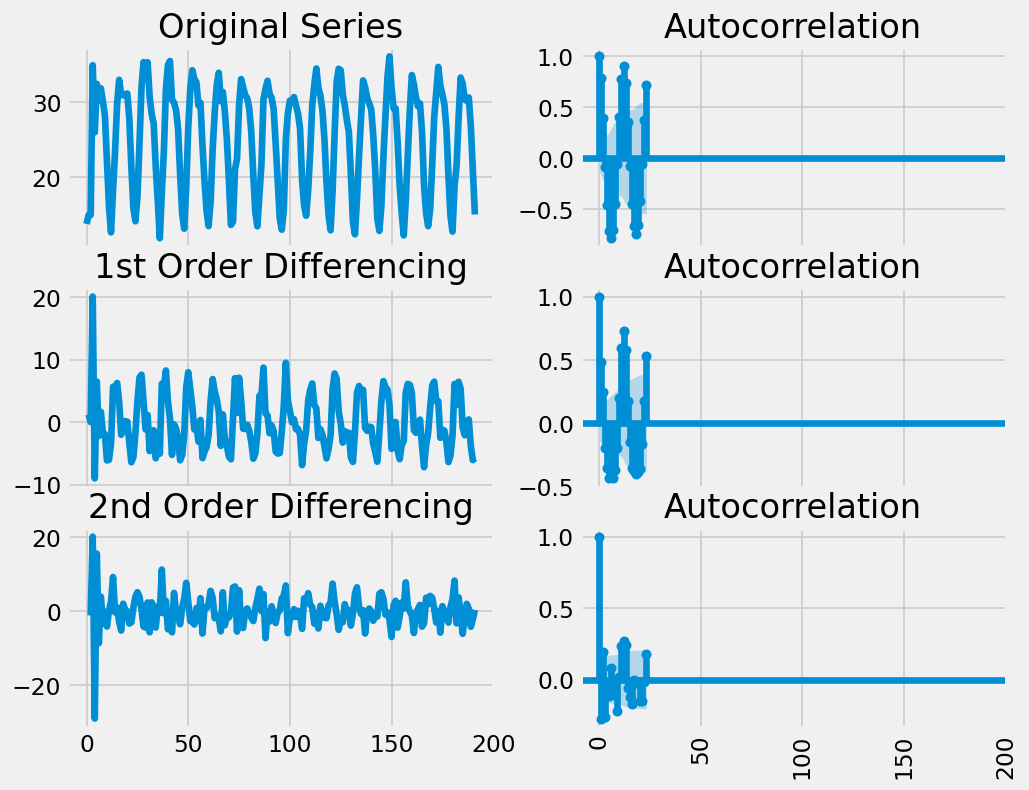

In [17]:
# Original Series
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_df.values); 
axes[0, 0].set_title('Original Series')
plot_acf(train_df.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_df.temprature.diff().values); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_df.diff().dropna().values,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_df.temprature.diff().diff().values); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_df.diff().diff().dropna().values,ax=axes[2, 1])

plt.xticks(rotation='vertical')
plt.show()

c:\python37\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


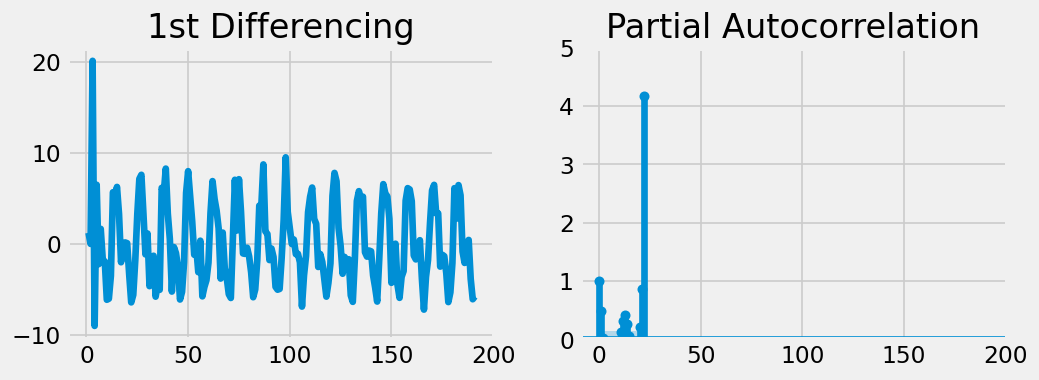

In [18]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

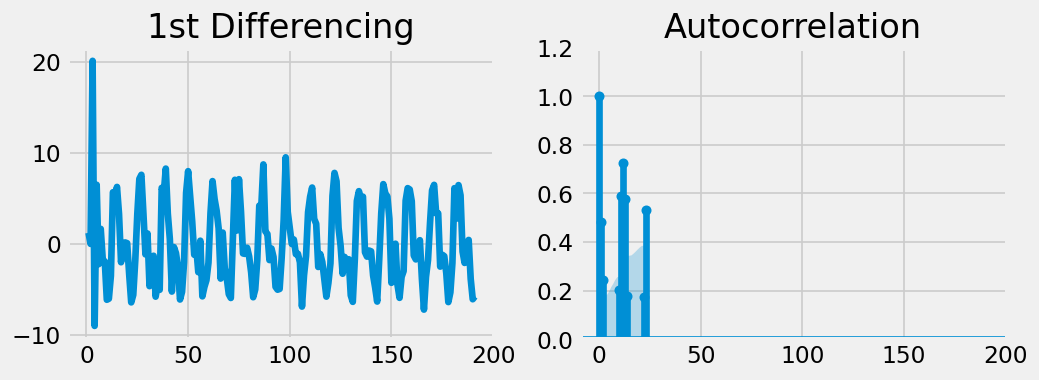

In [19]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

In [20]:
acf_lag = acf(train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

c:\python37\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
model = ARIMA(train_df.values, order=(2,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
fc, se, conf = model_fit.forecast(16, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()